In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition

In [27]:
def hog_distance(image1, image2):

    # Read the images
    img1 = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    img2 = cv2.imread(image2, cv2.IMREAD_UNCHANGED)

    # Convert to float
    img1_float = img1.astype(float)
    img2_float = img2.astype(float)

    # Normalize the image values to be between 0 and 1
    image1_normalized = (img1_float - img1_float.min()) / (img1_float.max() - img1_float.min())
    image2_normalized = (img2_float - img2_float.min()) / (img2_float.max() - img2_float.min())

    # Apply Canny edge detection
    edges1 = multi_scale_contour_detection_with_inhibition(image1_normalized, N=3, sigma=1, alpha=0.001)
    edges2 = multi_scale_contour_detection_with_inhibition(image2_normalized, N=3, sigma=1, alpha=0.001)

    # Create HOG object :
    hog1 = cv2.HOGDescriptor()
    hog2 = cv2.HOGDescriptor()

    # define each block as 4x4 cells of 64x64 pixels each
    cell_size = (64, 64)      # h x w in pixels
    block_size = (4, 4)         # h x w in cells
    win_size = (8, 6)           # h x w in cells

    nbins = 9  # number of orientation bins
    image1_size = img1.shape[:2]  # h x w in pixels

    # create a HOG object
    hog = cv2.HOGDescriptor(
        _winSize=(win_size[1] * cell_size[1],
                win_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1],
                    block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    n_cells = (image1_size[0] // cell_size[0], image1_size[1] // cell_size[1])

    # find features as a 1xN vector, then reshape into spatial hierarchy
    hog_feats = hog.compute(img1)
    hog_feats = hog_feats.reshape(
        n_cells[1] - win_size[1] + 1,
        n_cells[0] - win_size[0] + 1,
        win_size[1] - block_size[1] + 1,
        win_size[0] - block_size[0] + 1,
        block_size[1],
        block_size[0],
        nbins)
    

    print(hog_feats.shape)
    print(hog_feats)
    print(hog)

    plt.imshow(hog)
    plt.show()


    

(3, 1, 3, 5, 4, 4, 100)
[[[[[[[2.33095139e-02 1.51901331e-05 6.15927274e-05 ...
       4.31303743e-05 0.00000000e+00 2.33095139e-02]
      [3.23858149e-02 6.93462571e-05 3.53252370e-04 ...
       2.21069742e-04 0.00000000e+00 3.23858149e-02]
      [3.73641886e-02 0.00000000e+00 2.63547918e-05 ...
       2.15292355e-04 0.00000000e+00 3.73641886e-02]
      [2.03473866e-02 0.00000000e+00 0.00000000e+00 ...
       0.00000000e+00 0.00000000e+00 2.03473866e-02]]

     [[4.95746247e-02 0.00000000e+00 0.00000000e+00 ...
       0.00000000e+00 0.00000000e+00 4.95746247e-02]
      [5.71694300e-02 0.00000000e+00 0.00000000e+00 ...
       5.23899189e-06 0.00000000e+00 5.71694300e-02]
      [7.05984756e-02 0.00000000e+00 0.00000000e+00 ...
       8.44653914e-06 0.00000000e+00 7.05984756e-02]
      [4.91285771e-02 4.29003449e-05 6.27503032e-05 ...
       1.59235660e-05 2.71225417e-05 4.91285771e-02]]

     [[4.67504188e-02 0.00000000e+00 0.00000000e+00 ...
       0.00000000e+00 0.00000000e+00 4.67504

TypeError: Image data of dtype object cannot be converted to float

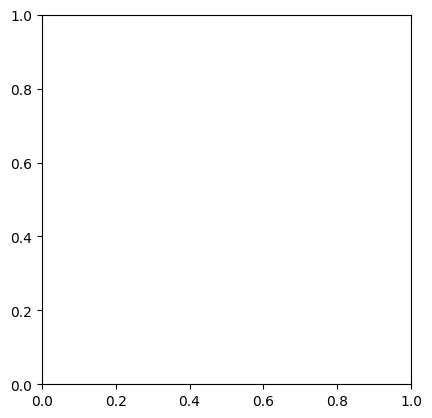

In [28]:
hog_distance('database/images/rino.pgm','database/images/rino.pgm')